In [ ]:
# this script uses data that I collect using the Twitter streaming API to analyze 
# where tweets are coming from and the sentiment of them. Preliminary figures show some 
# cool temporal dynamics and perhaps some cultural differences.
# Full dataset is ~30Gb and ~180 million tweets

In [1]:
import geopandas as gpd
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import datetime
import glob
import time
import os
import numpy as np

In [2]:
# load multiple sqlite DBs w/ scraped tweets
ts = np.vectorize(datetime.datetime.fromtimestamp)
os.chdir('/media/data/twitter/')
if not os.path.isfile('/media/data/twitter/twitter_data_clean.csv'):
    dbs = glob.glob('*db')
    data = []
    for db in dbs:
        print('loading ' + db) # I split these files up so any one isn't too big
        conn = sqlite3.connect(db)
        try:
            df = pd.read_sql("select unix, sentiment, loc_source, longitude, latitude, location from sentiment", conn) #  unix, sentiment, loc_source, longitude, latitude, location
        except:
            df = pd.read_sql("select unix, sentiment, longitude, latitude from sentiment", conn) #  unix, sentiment, loc_source, longitude, latitude, location
            # if we don't have location info, or lat/long.. we can drop some rows 
            # an older version of my scraper didn't save loc_source but still ~1/50 tweets has lat/long data
            df = df.dropna()
            df['location'] = ''
            df['loc_source'] = ''
        dates = ts(df.unix.values/1000)
        df.index = dates
        conn.close()
        data.append(df)

    df = pd.concat(data)
    del data, dates
    df = df.sort_index()
    df.to_csv('twitter_data_clean.csv')
else:
    df = pd.read_csv('twitter_data_clean.csv')

loading 20210615-102758_twitter.db
loading twitter_fall.db
loading 20210703-133946_twitter.db
loading 20210613-104941_twitter.db
loading 20210703-122204_twitter.db
loading 20210704-115426_twitter.db
loading 20210615-172857_twitter.db
loading twitter_spring.db
loading 20210616-180158_twitter.db
loading 20210616-090825_twitter.db
loading twitter_geo3.db
loading twitter_2.db


<ipython-input-2-bcf873d71487>:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(data)


In [3]:
# we are going to attempt to geocode unlabelled tweets by the 'location' listed for users that share this.. fully aware that this won't be correct (or a real place) for many
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="twitter_geo")

print('started with: ', sum(df.latitude.isnull()), ' missing locations')

n = 10 # n is the number of places we will try to get lat/long coord for, sorted by most common places
locs = df['location'].value_counts()[:n].index.tolist()

lon = int(np.where(df.columns=='longitude')[0])
lat = int(np.where(df.columns=='latitude')[0])

for loc in locs:
    try:
        lo  = geolocator.geocode(loc,timeout=5) # get coords for a place
        idx = np.where(df.location==loc)
        for ind in idx[0]:
            df.iat[ind,lon] = lo.longitude
            df.iat[ind,lat] = lo.latitude   
    except:
        pass
    
print('ended with: ', sum(df.latitude.isnull()), ' missing locations')
print('working with: ', sum(df.latitude.notnull()), ' locations')

started with:  180955104  missing locations
ended with:  170993675  missing locations
working with:  12982010  locations


In [5]:
# let's only keep the complete data
df = df[df['latitude'].notnull()]
print(len(df))
df.tail()

12982010


,latitude,loc_source,locatin,location,longitude,sentiment,unix
2021-07-05 12:17:59.656,54.486226,place,NaN,,-1.536542,0.3818,1.625502e+12
2021-07-05 12:18:04.622,51.507322,user,NaN,"London, England",-0.127647,0.7935,1.625502e+12
2021-07-05 12:18:09.624,35.117241,user,NaN,she/her,-89.913269,0.1531,1.625502e+12
2021-07-05 12:18:09.664,36.701463,user,NaN,"California, USA",-118.755997,0.4995,1.625502e+12
2021-07-05 12:18:13.664,39.783730,user,NaN,United States,-100.445882,0.5837,1.625502e+12


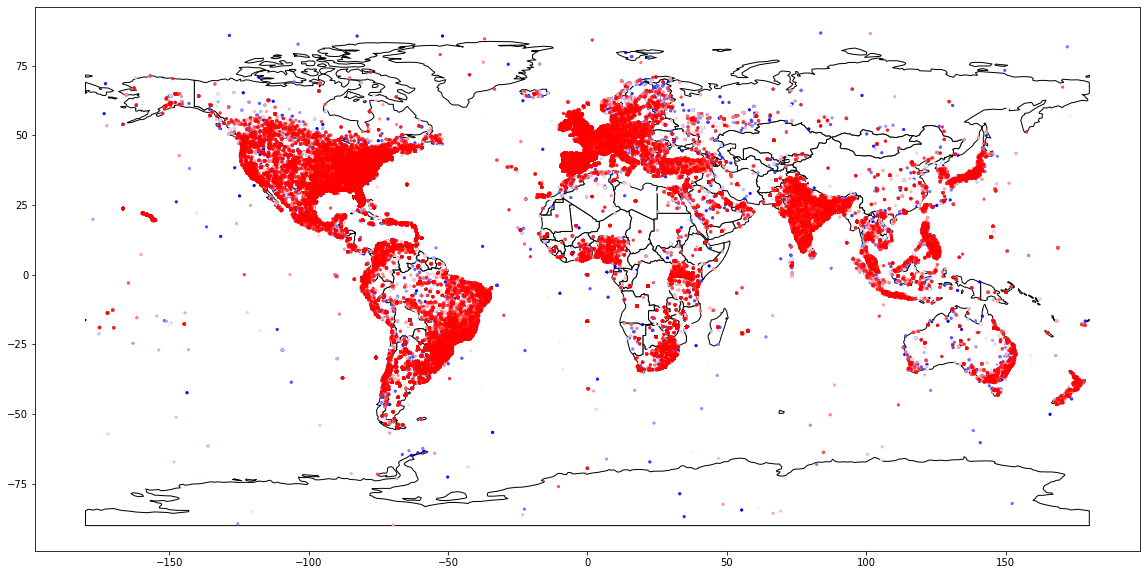

In [6]:
# let's see where tweets are coming from... pretty cool coverage
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)   

# #this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 10),edgecolor='k',color='w'), marker='o', cmap='bwr', markersize=5,vmin=-1,vmax=1)

In [7]:
# make a geoDataFrame using lat/long of tweets
places = gdf
places["geometry"] = gdf.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
places = gpd.GeoDataFrame(places, geometry="geometry")
places.crs = {"init": "epsg:4326"}

# Load the countries polygons
country_shapes = world[['geometry', 'iso_a3']]
country_names = world[['name', 'iso_a3']]
countries = world[['geometry', 'name']]
countries = countries.rename(columns={'name':'country'})

# join tweet lat/long with country shapes (i.e. borders)
result = gpd.tools.sjoin(places, countries, how="left")

In [8]:
# get the overall median and latest (4h) z-scored average sentiment values for each country, as heatmaps
sentAvg = []
sentLastHr = []

for country in world['name']:
    sentAvg.append(result.loc[result['country']==country]['sentiment'].median())
    sentLastHr.append((result.loc[result['country']==country]['sentiment'].last('4h').mean()-result.loc[result['country']==country]['sentiment'].mean())/result.loc[result['country']==country]['sentiment'].std())
    
world['sentiment'] = sentAvg
world['sentiment_lastHr'] = sentLastHr

Text(0.5, 1, 'total')

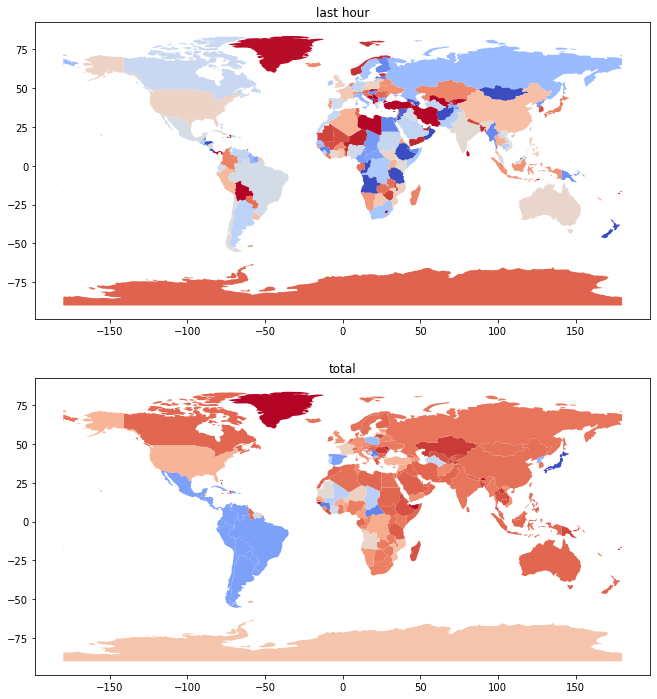

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(30,12))

world.dropna().plot(ax=axes[0],column='sentiment_lastHr',cmap='coolwarm',legend=False,vmin=-1,vmax=1) 
axes[0].set_title('last hour')

world.dropna().plot(ax=axes[1],column='sentiment',cmap='coolwarm',legend=False,vmin=-.5,vmax=.5) 
axes[1].set_title('total')
# interesting differences on average.. Japand and South American tend to have reliably lower sentiment values? Linguistic difference in how english is used?

Text(0.5, 1.0, "('United States of America', 8677660)")

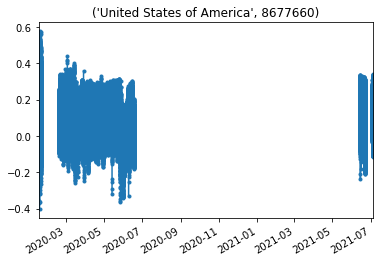

In [9]:
# let's look at temporal dynamics
result[result['country']=='United States of America']['sentiment'].rolling('200S',min_periods=10).mean().plot(marker='.')
plt.title(('United States of America',len(result.loc[result['country']=='United States of America'])))
# plt.xlim((datetime.datetime(2021,7,3,5,48),datetime.datetime.now()))


(737485.075, 737607.2416666667)

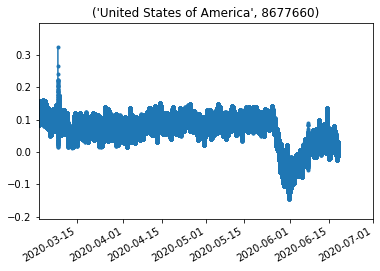

In [20]:
# zoom in on a timewindow w/ good coverage
result[result['country']=='United States of America']['sentiment'].rolling('1H',min_periods=10).mean().plot(marker='.')
plt.title(('United States of America',len(result.loc[result['country']=='United States of America'])))
# plt.xlim((datetime.datetime(2021,7,3,5,48),datetime.datetime.now()))
plt.xlim((datetime.datetime(2020,3,1,1,48),datetime.datetime(2020,7,1,5,48)))

# can you guess from this plot when BLM protests began after the murder of George Floyd?